In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split

---------------------

# Retrieving and Preprocess Data

Image size:  100


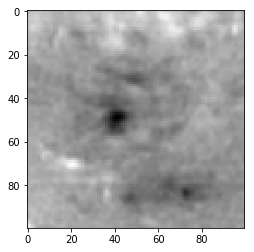

In [2]:
dataset = np.load('/home/kevinteng/Desktop/DeepLearning/Tensorflow2_0/test_npy/7-12-17-processed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
re_list = re_list.astype('float32')

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

(100, 100, 1) float32


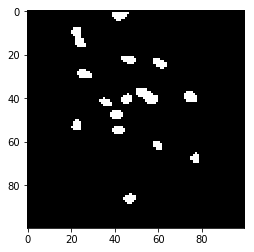

In [3]:
#retrieve and plot mean_ROI
mean_roi = np.load("/home/kevinteng/Desktop/mat/Ori_Lin/dg-13-7-12-17ROIs.mat_ROImask.npy")
mean_roi = cv2.resize(mean_roi, (NEW_SIZE, NEW_SIZE))
#Dimension for network should include the color channel 
mean_roi = np.expand_dims(mean_roi, axis = -1)
#Cast data type to float32 for TensorFlow
mean_roi = mean_roi.astype('float32')

print(mean_roi.shape, mean_roi.dtype)
plt.imshow(np.squeeze(mean_roi), cmap = 'gray')

In [4]:
# centres, img_with_centroids = utils.retrieve_centroid(mean_roi, centroid_rad = 2)

# plt.imshow(np.squeeze(img_with_centroids), cmap = 'gray')
# plt.show()
# print('With centroids:')
# print(centres)

In [5]:
#calculate mean image

mean_img_ori = utils.mean_image(re_list, IMG_SIZE)
#apply min max norm for mean image
mean_img_ori = utils.min_max_norm(mean_img_ori)
mean_img_ori = np.expand_dims(mean_img_ori, -1)
print('Max value:', np.max(mean_img_ori))
print('Min value:', np.min(mean_img_ori))


Max value: 1.0
Min value: 0.0


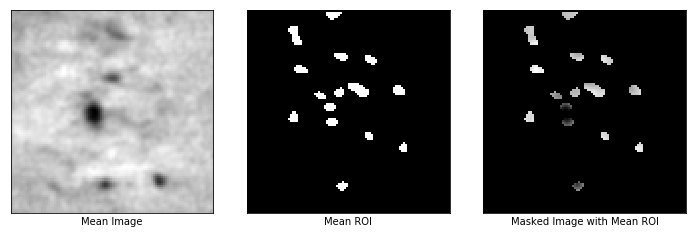

MSE:  0.590009163549358
Dice coefficient:  0.05908616320337883


In [6]:
from utils import masked_img, dice_coef_py, MSE_image
from utils_vis import plot_comparison

captions = ['Mean Image', 'Mean ROI', 'Masked Image with Mean ROI']
plot_comparison([mean_img_ori, mean_roi,masked_img(mean_img_ori, mean_roi)], 
                captions, n_col =3, figsize = (10, 10))
print('MSE: ', MSE_image(np.squeeze(mean_img_ori), mean_roi, IMG_SIZE))
#measure IOU with dice coeff
print('Dice coefficient: ',dice_coef_py(mean_roi, mean_img_ori))

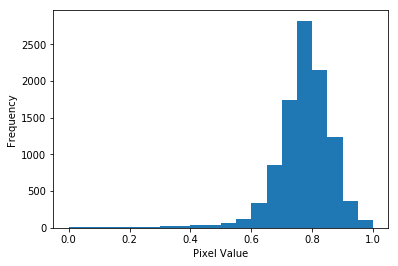

In [7]:
#plot historgram for mean image
plt.hist(mean_img_ori.ravel(),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Model

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block


l1_coeff = 0.99
#filters_layer = [16, 32, 64, 32, 16]
filters_layer = [32, 64]

#build network
def Coord_conv(input_layer):
    coordconv_01 = coordconv_block(input_layer, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[0], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True)
    coordconv_02 = coordconv_block(coordconv_01, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = filters_layer[1], kernel_size = 3, strides = 1, padding='same', 
                                       activation='relu', batch_norm = True,
                                   l1_coeff = l1_coeff)
    coordconv_03 = coordconv_block(coordconv_02, x_dim = IMG_SIZE, y_dim = IMG_SIZE, 
                                      filters = 1, kernel_size = 3, strides = 1, padding='same', 
                                       activation='sigmoid')
    return coordconv_03

def Convnet(input_layer):
    conv_01 = conv_block(input_layer, filters = filters_layer[0], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',batch_norm = True) 
    conv_02 = conv_block(conv_01, filters = filters_layer[1], kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'relu',
                         batch_norm = True, l1_coeff = l1_coeff)
    conv_03 = conv_block(conv_02, filters = 1, kernel_size = 3, strides = 1, 
                             padding = 'same',  activation = 'sigmoid') 
    return conv_03
        
        

## Build Model

In [9]:
coordconv = True #toggle for coordconv and regular convnet
input_layer = Input(shape = (IMG_SIZE, IMG_SIZE, 1))

if coordconv:
    print('The model is in Coordconv')
    model = Model(input_layer, Coord_conv(input_layer))
else:
    print('The model is in regular Conv-net')
    model = Model(input_layer, Convnet(input_layer))

The model is in Coordconv
L1 kernel regularizer is activate!


-----------------------------------------------------------------

## Train Model

In [10]:
def batch_dataset(inp_imgs, BATCH_SIZE, IMG_SIZE):
    n_batch = int(len(inp_imgs)/BATCH_SIZE)
    mod = len(inp_imgs)%BATCH_SIZE
    if mod == 0:
        batch_imgs = np.reshape(inp_imgs,(n_batch, BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1))
    else: 
        #divisible part
        divisible = inp_imgs[:(len(inp_imgs)-mod)]
        divisible_re = np.reshape(divisible, (n_batch, BATCH_SIZE, IMG_SIZE, IMG_SIZE, 1))
        
        #remainder part
        remainder = inp_imgs[(len(inp_imgs)-mod):]
        #remainder shape must be padded to be the same as divisible shape
        #else python will return array of type "object" which tensorflow 
        #cannot convert it to tensor
        pad_dim = int(BATCH_SIZE - mod)
        pad_array = np.zeros((pad_dim, IMG_SIZE, IMG_SIZE, 1))
        remainder_pad = np.concatenate((remainder, pad_array), axis = 0)        
        #normalize trick for remainder to balance the mean of zeros array padding
        #such that in tf.reduce_mean, mean of remainder_pad = remainder_pad/BATCH_SIZE
        #which in this case, the true mean becomes remainder_pad/len(remainder)
        remainder_pad*= (BATCH_SIZE/len(remainder))
        remainder_pad = np.expand_dims(remainder_pad, 0)

        #stack divisible and remainder
        batch_imgs = np.concatenate((divisible_re, remainder_pad), 0).astype('float32')
    
    return batch_imgs

In [11]:
from utils_model import img_mean, min_max_norm

#hyperparameter
BATCH_SIZE = 32
lr = 0.001
#loss function
loss_fn = tf.losses.MeanSquaredError()

#annealer = lambda x: lr * 0.8 ** x
#optimizer 
opt = tf.optimizers.Adam(lr)

@tf.function
def train(batched_imgs, mean_roi, img_size):
    with tf.GradientTape() as tape:
        stack_batch = tf.zeros((img_size,img_size))
        sums = 0
        
        #loop for batches 
        for img_batch in batched_imgs:
            stack = tf.zeros((img_size,img_size))
            
            #feed the network with batches 
            conv_img = model(img_batch)
            #take the mean of the batch 
            batch_mean = tf.reduce_mean(conv_img, 0)
            #stack the number of batch for each loop in number of batches
            stack_batch+= tf.squeeze(batch_mean)
            sums+=1
        
        #total mean of 
        mean_img=stack_batch/tf.cast(sums, dtype = tf.dtypes.float32)
        #ensure that the size of the images match during loss calculationta
        mean_img=tf.reshape(mean_img, [img_size, img_size, 1])
        xent = loss_fn(mean_roi, mean_img)

    grads = tape.gradient(xent, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    
    return xent, mean_img, grads

ori_list = [] #original image list
de_list = [] #mean image fromt the network list
loss_list = [] #loss list

img_batch = re_list
epochs = 0

batch_imgs = batch_dataset(re_list, BATCH_SIZE, IMG_SIZE)

while epochs < 50:
    xent, mean_img, grads =train(batch_imgs, mean_roi, IMG_SIZE)
    de_list.append(mean_img)
    loss_list.append(xent)

    print("Epochs {:2d}, Loss: {}".format(epochs, xent.numpy()))
    print("Gradient min:{}, max:{}".format(np.min(grads[0]), np.max(grads[0])))
    print()
    epochs+=1

Epochs  0, Loss: 0.9137126803398132
Gradient min:-0.3952826261520386, max:0.47234559059143066

Epochs  1, Loss: 0.033028002828359604
Gradient min:-0.01364751998335123, max:0.010563068091869354

Epochs  2, Loss: 0.03314770385622978
Gradient min:-0.0005982532748021185, max:0.0008279331377707422

Epochs  3, Loss: 0.0332915298640728
Gradient min:-0.00010202030534856021, max:0.00019933471048716456

Epochs  4, Loss: 0.03332851082086563
Gradient min:-2.806998963933438e-05, max:8.014731429284438e-05

Epochs  5, Loss: 0.033343151211738586
Gradient min:-1.0046396710094996e-05, max:4.248344703228213e-05

Epochs  6, Loss: 0.033350683748722076
Gradient min:-9.100759598368313e-06, max:2.5640947569627315e-05

Epochs  7, Loss: 0.03335524722933769
Gradient min:-9.326265171694104e-06, max:1.690284079813864e-05

Epochs  8, Loss: 0.03335832059383392
Gradient min:-9.55519499257207e-06, max:1.1860365702887066e-05

Epochs  9, Loss: 0.03336051478981972
Gradient min:-9.731211321195588e-06, max:8.72967939358204

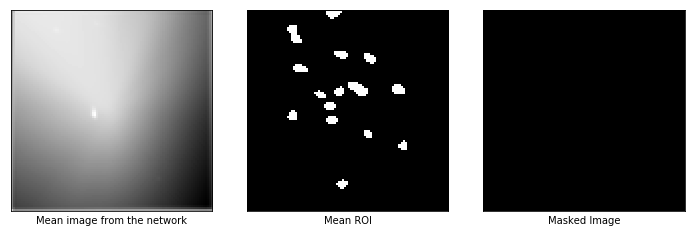

Loss: 0.03335346
Dice coefficient:  0.004247115486685242



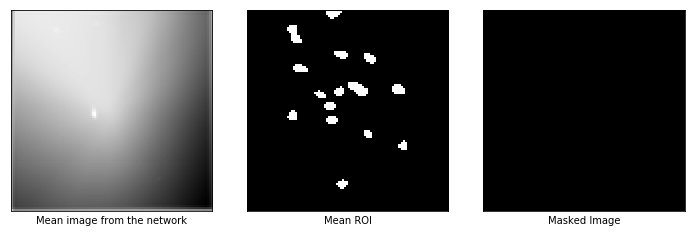

Loss: 0.033352852
Dice coefficient:  0.004264245523796752



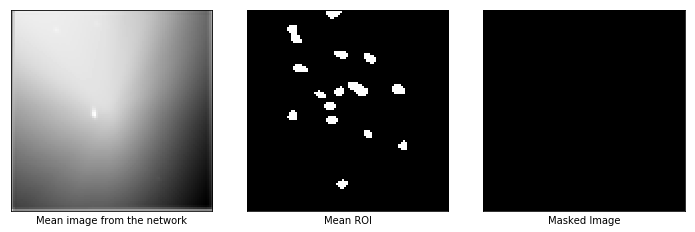

Loss: 0.03335223
Dice coefficient:  0.004281624114676897



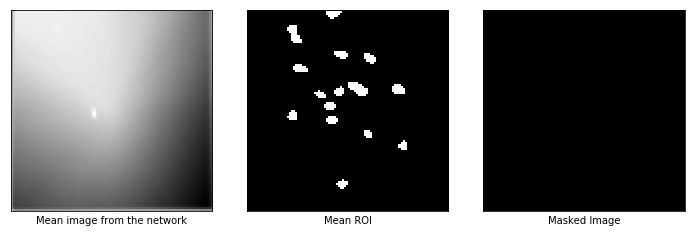

Loss: 0.033351604
Dice coefficient:  0.004299241458929419



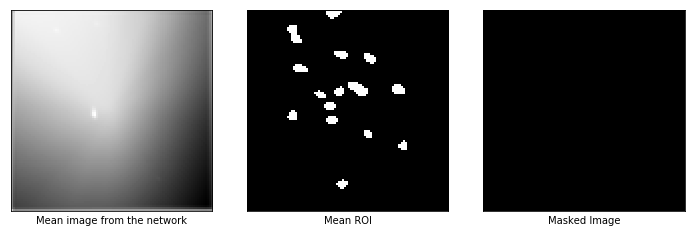

Loss: 0.033350978
Dice coefficient:  0.0043170321960394106


In [12]:
#plot for mean image of last 10 steps w.r.t mean roi 
last_n_steps = 5
for i in range(last_n_steps):
    mean_image = de_list[len(de_list) - last_n_steps + i]
    mean_image = np.asarray(mean_image) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    
    #plot
    inp_imgs = [mean_image , mean_roi, masked_image]
    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions,n_col = 3, figsize = (10,10))
    
    print('Loss:', loss_list[len(de_list) - last_n_steps + i].numpy())
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))

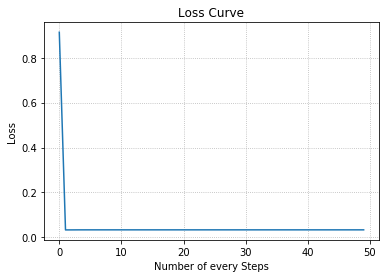

In [13]:
utils_vis.plot_loss(loss_list)

-------------------------------------------------

# Predict

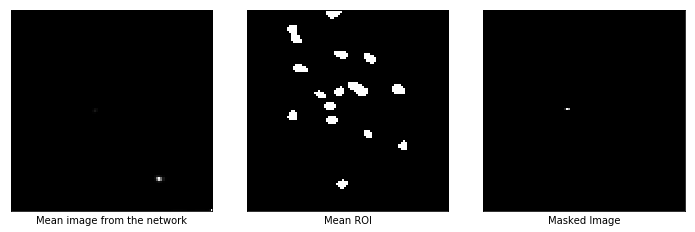

MSE for predicted image:  0.033839834594726566
Dice coefficient:  0.0005975028879672341



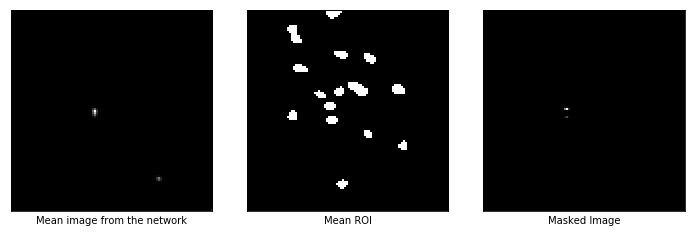

MSE for predicted image:  0.033598092651367185
Dice coefficient:  0.005284623514809271



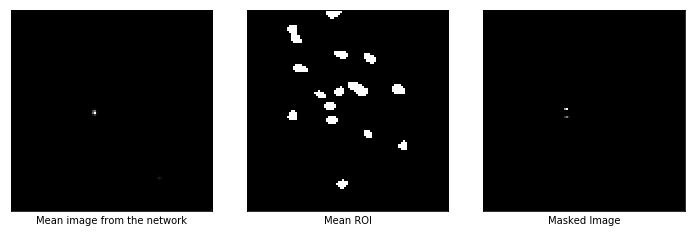

MSE for predicted image:  0.03363952331542969
Dice coefficient:  0.0006912441017877265



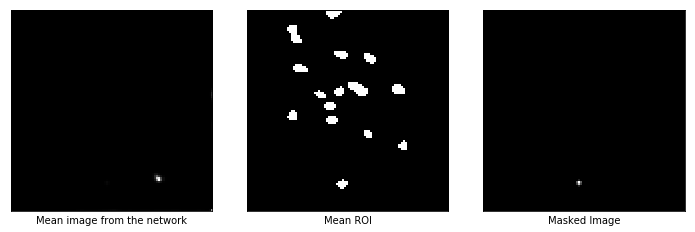

MSE for predicted image:  0.033854428100585934
Dice coefficient:  0.0007410870473314723



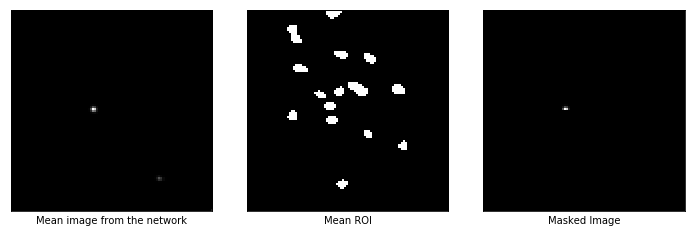

MSE for predicted image:  0.03316740112304688
Dice coefficient:  0.017534801929170875


In [14]:
sums = 0
slices = 20 #slices of image from image stack 
n = 5

#create data generator for test set
ds_test = tf.data.Dataset.from_tensor_slices(re_list).batch(slices)

for i, (test_batch) in enumerate(ds_test):
    assert test_batch.shape[0] == slices

    conv_img = model(test_batch)
    mean_img = img_mean(conv_img, IMG_SIZE)
    mean_img = min_max_norm(mean_img)

    mean_image = np.asarray(mean_img) #cast tf object into np array
    masked_image = masked_img(mean_image, mean_roi)
    inp_imgs = [np.squeeze(mean_img), mean_roi, masked_image]

    captions = ['Mean image from the network',
               'Mean ROI', 
               'Masked Image']
    plot_comparison(inp_imgs, captions, n_col = 3,figsize = (10,10))

    print('MSE for predicted image: ', MSE_image(mean_img, mean_roi, IMG_SIZE))
    print('Dice coefficient: ', dice_coef_py(mean_roi, mean_image))
    
    sums+=1
    
    #plot only n images for prediction
    if sums == n:
        break

-----------------------------------------------

# Visualizing Feature Maps

In [15]:
from utils_vis import layers_dict, feature_maps, plot_feature_maps, layers_name

layer_dict = layers_dict(model)
layer_name = layers_name(model)

input_1
coord_conv_1
batch_normalization_v2
activation
coord_conv_3
batch_normalization_v2_1
activation_1
coord_conv_5
activation_2


In [21]:
if coordconv:
    layer_name = 'coord_conv'
else:
    layer_name = 'conv2d'
    
# layer_output = layer_dict[layer_name].output

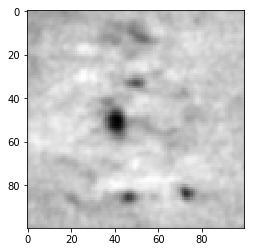

In [18]:
# taking the mean over all stacks as input
test_img = np.asarray(tf.expand_dims(mean_img_ori, 0)) #(1, img size, img size, 1)
#test_img = tf.expand_dims(test_img, -1) #(1, img size, img size, 1)
plt.imshow(np.squeeze(test_img), cmap = 'gray')
plt.show()

## Visualizing Last Layer of Feature Maps

Shape of feature maps: (1, 100, 100, 64)
Number of feature maps in layer:  64


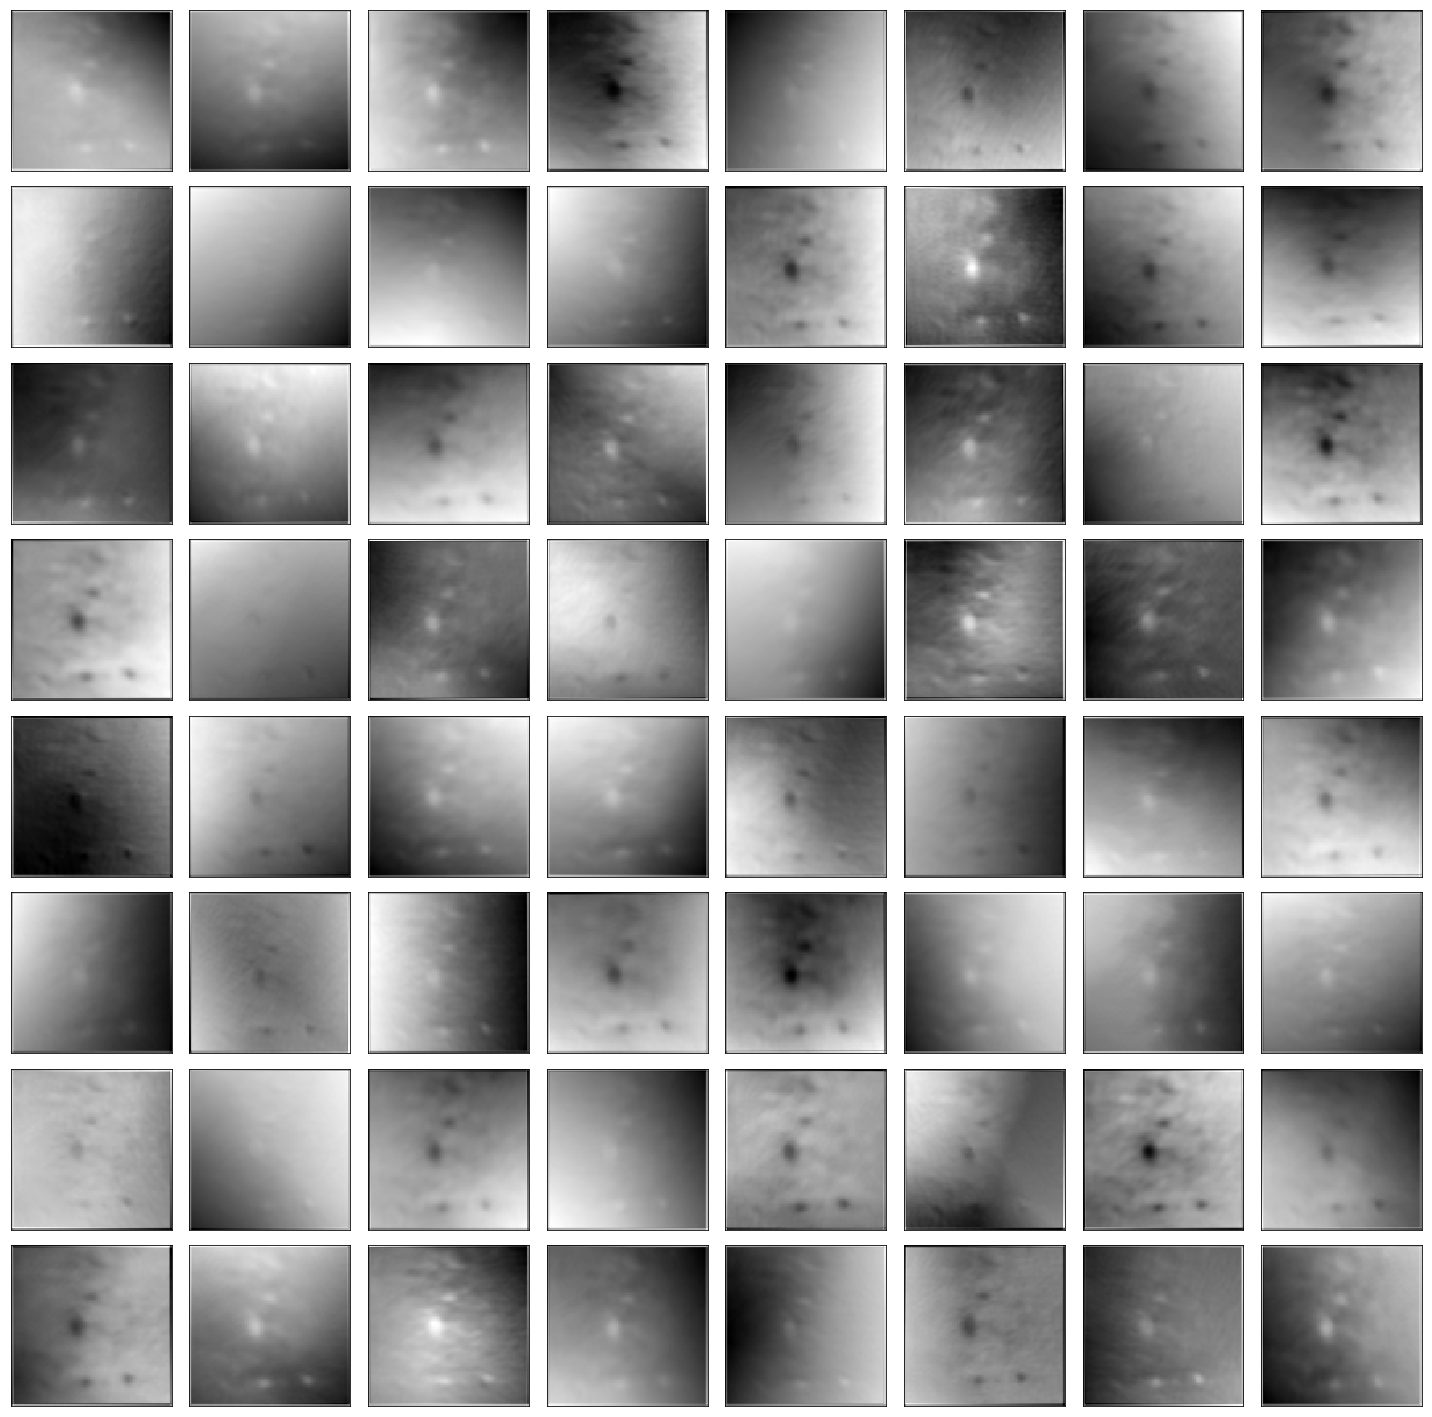

In [19]:
test_map = feature_maps(model, '{}_3'.format(layer_name), test_img)
plot_feature_maps(test_map, 8, 8, figsize = (20,20))

## Visualizing First Layer of Feature Maps

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


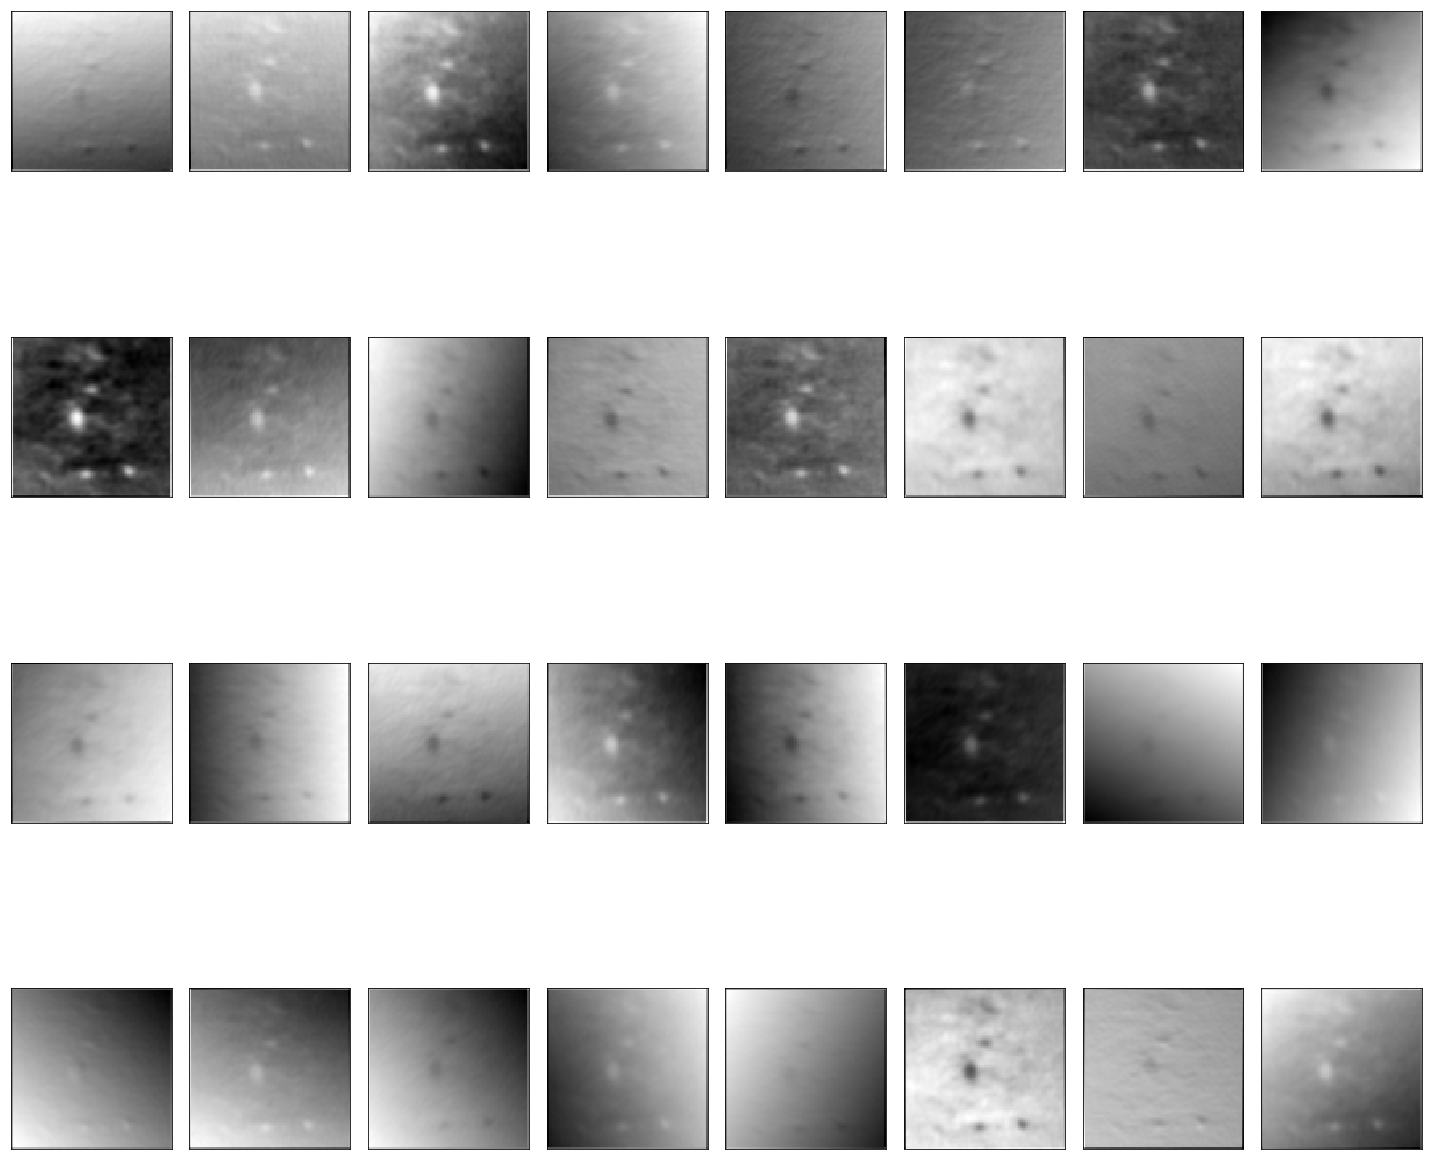

In [20]:
test_map02 = feature_maps(model, '{}_1'.format(layer_name), test_img)
plot_feature_maps(test_map02, 4, 8, figsize = (20,20))

--------------------------------

# Appendix

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
coord_conv_1 (CoordConv)     (None, 100, 100, 32)      896       
_________________________________________________________________
batch_normalization_v2 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 32)      0         
_________________________________________________________________
coord_conv_3 (CoordConv)     (None, 100, 100, 64)      19648     
_________________________________________________________________
batch_normalization_v2_1 (Ba (None, 100, 100, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 100, 100, 64)      0     